In [1]:
import os
import time

from netunicorn.client.remote import RemoteClient, RemoteClientException
from netunicorn.base import Experiment, ExperimentStatus, Pipeline

# Tasks to start tcpdump and stop named tcpdump task
from netunicorn.library.tasks.capture.tcpdump import StartCaptureLinuxImplementation, StopNamedCaptureLinuxImplementation

# Tasks for watching the corresponding video platform
from netunicorn.library.tasks.video_watchers.youtube_watcher import WatchYouTubeVideoLinuxImplementation
from netunicorn.library.tasks.video_watchers.vimeo_watcher import WatchVimeoVideoLinuxImplementation

from netunicorn.library.tasks.measurements.ookla_speedtest import SpeedTestLinuxImplementation
from netunicorn.library.tasks.measurements.flent import RRULTest, FlentCommand

In [2]:
pipeline = Pipeline()
pipeline.early_stopping = False

pipeline.then(StartCaptureLinuxImplementation(filepath="/tmp/capture_youtube.pcap", name="capture_youtube"))
for _ in range(4):
    pipeline.then(WatchYouTubeVideoLinuxImplementation("https://www.youtube.com/watch?v=dQw4w9WgXcQ", 20))
pipeline.then(StopNamedCaptureLinuxImplementation(capture_task_name="capture_youtube"))

pipeline.then(StartCaptureLinuxImplementation(filepath="/tmp/capture_vimeo.pcap", name="capture_vimeo"))
for _ in range(4):
    pipeline.then(WatchVimeoVideoLinuxImplementation("https://vimeo.com/375468729", 20))
pipeline.then(StopNamedCaptureLinuxImplementation(capture_task_name="capture_vimeo"))

for element in pipeline.tasks:
    print(element)

[<netunicorn.library.tasks.capture.tcpdump.StartCaptureLinuxImplementation with name capture_youtube>]
[<netunicorn.library.tasks.video_watchers.youtube_watcher.WatchYouTubeVideoLinuxImplementation with name 1dab62aa-c140-4901-b3b6-52af8fe50fff>]
[<netunicorn.library.tasks.video_watchers.youtube_watcher.WatchYouTubeVideoLinuxImplementation with name 11214f0d-65d6-4d25-83f3-dc906aeab98e>]
[<netunicorn.library.tasks.video_watchers.youtube_watcher.WatchYouTubeVideoLinuxImplementation with name f4a0c78e-1b2a-4266-9477-48af17b28dbc>]
[<netunicorn.library.tasks.video_watchers.youtube_watcher.WatchYouTubeVideoLinuxImplementation with name da12e44d-dd77-4fd9-a4c9-3b20ba63ea42>]
[<netunicorn.library.tasks.capture.tcpdump.StopNamedCaptureLinuxImplementation with name 285a1cf1-2833-4a3d-89b4-24aa8d6ee4b5>]
[<netunicorn.library.tasks.capture.tcpdump.StartCaptureLinuxImplementation with name capture_vimeo>]
[<netunicorn.library.tasks.video_watchers.vimeo_watcher.WatchVimeoVideoLinuxImplementation w

In [3]:
# if you have .env file locally for storing credentials, skip otherwise
if '.env' in os.listdir():
    from dotenv import load_dotenv
    load_dotenv(".env")

NETUNICORN_ENDPOINT = os.environ.get('NETUNICORN_ENDPOINT', 'http://localhost:26611')
NETUNICORN_LOGIN = os.environ.get('NETUNICORN_LOGIN', 'test')
NETUNICORN_PASSWORD = os.environ.get('NETUNICORN_PASSWORD', 'test')

client = RemoteClient(endpoint=NETUNICORN_ENDPOINT, login=NETUNICORN_LOGIN, password=NETUNICORN_PASSWORD)
client.healthcheck()

True

In [4]:
nodes = client.get_nodes()

# switch for showing our infrastructure vs you doing it locally on other nodes
if os.environ.get('NETUNICORN_ENDPOINT', 'http://localhost:26611') != 'http://localhost:26611':
    working_nodes = nodes.filter(lambda node: node.name.startswith("raspi")).take(5)
else:
    working_nodes = nodes.take(1)

working_nodes

[dockerhost]

In [5]:
# Creating the experiment
experiment = Experiment().map(pipeline, working_nodes)
experiment

 - Deployment: Node=dockerhost, executor_id=, prepared=False

In [6]:
from netunicorn.base import DockerImage
for deployment in experiment:
    # you can explore the image on the DockerHub
    deployment.environment_definition = DockerImage(image='pinot.cs.ucsb.edu/sigcommtutorial:latest')
    deployment.environment_definition.runtime_context.additional_arguments = ["/tmp:/tmp"]
    deployment.cleanup = False

In [7]:
!rm -rf /tmp/capture*

In [8]:
experiment_label = "tut02"

In [9]:
try:
    client.delete_experiment(experiment_label)
except RemoteClientException:
    pass

client.prepare_experiment(experiment, experiment_label)
time.sleep(2)

In [10]:
while True:
    info = client.get_experiment_status(experiment_label)
    print(info.status)
    if info.status == ExperimentStatus.READY:
        break
    time.sleep(10)

ExperimentStatus.PREPARING
ExperimentStatus.PREPARING
ExperimentStatus.READY


In [11]:
for deployment in client.get_experiment_status(experiment_label).experiment:
    print(f"Prepared: {deployment.prepared}, error: {deployment.error}")

Prepared: True, error: None


In [12]:
client.start_execution(experiment_label)

'tut02'

In [13]:
while True:
    info = client.get_experiment_status(experiment_label)
    print(info.status)
    if info.status != ExperimentStatus.RUNNING:
        break
    time.sleep(10)

ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.RUNNING
ExperimentStatus.FINISHED


In [14]:
from returns.pipeline import is_successful

for report in info.execution_result:
    print(f"Node name: {report.node.name}")
    print(f"Error: {report.error}")

    result, log = report.result  # report stores results of execution and corresponding log
    
    # result is a returns.result.Result object, could be Success of Failure
    print(f"Result is: {type(result)}")
    data = result.unwrap() if is_successful(result) else result.failure()
    for key, value in data.items():
        print(f"{key}: {value}")

    # we also can explore logs
    for line in log:
        print(line.strip())
    print()

Node name: dockerhost
Error: None
Result is: <class 'returns.result.Failure'>
capture_youtube: [<Success: 10>]
1dab62aa-c140-4901-b3b6-52af8fe50fff: [<Failure: Couldn't start the video: unknown error>]
11214f0d-65d6-4d25-83f3-dc906aeab98e: [<Success: Video finished by timeout: 20 seconds>]
f4a0c78e-1b2a-4266-9477-48af17b28dbc: [<Success: Video finished by timeout: 20 seconds>]
da12e44d-dd77-4fd9-a4c9-3b20ba63ea42: [<Success: Video finished by timeout: 20 seconds>]
285a1cf1-2833-4a3d-89b4-24aa8d6ee4b5: [<Success: b''>]
capture_vimeo: [<Success: 769>]
a742a754-98d2-4b58-ba24-1690204b605a: [<Success: Video finished by timeout: 20 seconds>]
11560b79-cd29-4f5e-a71d-1ffb872809a3: [<Success: Video finished by timeout: 20 seconds>]
2ddff2a5-93f3-40e3-ac92-3cb019069853: [<Success: Video finished by timeout: 20 seconds>]
8b01cf9d-3258-4423-be64-e6f55e0aa951: [<Success: Video finished by timeout: 20 seconds>]
a492a5b2-d7a9-41ea-a559-2119cc1ed9cb: [<Success: b''>]
Parsed configuration: Gateway loc

In [15]:
!docker run -v /tmp/capture_youtube.pcap:/tmp/capture_youtube.pcap -v /tmp:/tmp/output --rm pinot.cs.ucsb.edu/cicflowmeter:latest /tmp/capture_youtube.pcap /tmp/output

cic.cs.unb.ca.ifm.Cmd You select: /tmp/capture_youtube.pcap
cic.cs.unb.ca.ifm.Cmd Out folder: /tmp/output
cic.cs.unb.ca.ifm.Cmd CICFlowMeter received 1 pcap file
Working on... capture_youtube.pcap
cic.cs.unb.ca.jnetpcap.FlowGenerator Forward flow closed due to FIN Flag
cic.cs.unb.ca.jnetpcap.FlowGenerator Forward flow closed due to FIN Flag
cic.cs.unb.ca.jnetpcap.FlowGenerator Forward flow closed due to FIN Flag
cic.cs.unb.ca.jnetpcap.FlowGenerator Forward flow closed due to FIN Flag
cic.cs.unb.ca.jnetpcap.FlowGenerator Forward flow closed due to FIN Flag
cic.cs.unb.ca.jnetpcap.FlowGenerator Forward flow closed due to FIN Flag
cic.cs.unb.ca.jnetpcap.FlowGenerator Forward flow closed due to FIN Flag
cic.cs.unb.ca.jnetpcap.FlowGenerator Forward flow closed due to FIN Flag
cic.cs.unb.ca.jnetpcap.FlowGenerator Forward flow closed due to FIN Flag
cic.cs.unb.ca.jnetpcap.FlowGenerator Forward flow closed due to FIN Flag
cic.cs.unb.ca.jnetpcap.FlowGenerator Forward flow closed due to FIN Flag


In [16]:
!docker run -v /tmp/capture_vimeo.pcap:/tmp/capture_vimeo.pcap -v /tmp:/tmp/output --rm pinot.cs.ucsb.edu/cicflowmeter:latest /tmp/capture_vimeo.pcap /tmp/output

cic.cs.unb.ca.ifm.Cmd You select: /tmp/capture_vimeo.pcap
cic.cs.unb.ca.ifm.Cmd Out folder: /tmp/output
cic.cs.unb.ca.ifm.Cmd CICFlowMeter received 1 pcap file
Working on... capture_vimeo.pcap
cic.cs.unb.ca.jnetpcap.FlowGenerator Forward flow closed due to FIN Flag
cic.cs.unb.ca.jnetpcap.FlowGenerator Forward flow closed due to FIN Flag
cic.cs.unb.ca.jnetpcap.FlowGenerator Forward flow closed due to FIN Flag
cic.cs.unb.ca.jnetpcap.FlowGenerator Forward flow closed due to FIN Flag
cic.cs.unb.ca.jnetpcap.FlowGenerator Forward flow closed due to FIN Flag
cic.cs.unb.ca.jnetpcap.FlowGenerator Forward flow closed due to FIN Flag
cic.cs.unb.ca.jnetpcap.FlowGenerator Forward flow closed due to FIN Flag
cic.cs.unb.ca.jnetpcap.FlowGenerator Forward flow closed due to FIN Flag
cic.cs.unb.ca.jnetpcap.FlowGenerator Forward flow closed due to FIN Flag
cic.cs.unb.ca.jnetpcap.FlowGenerator Forward flow closed due to FIN Flag
cic.cs.unb.ca.jnetpcap.FlowGenerator Forward flow closed due to FIN Flag
cic.

In [17]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [18]:
df_youtube = pd.read_csv("/tmp/capture_youtube.pcap_Flow.csv")
df_vimeo = pd.read_csv("/tmp/capture_vimeo.pcap_Flow.csv")

In [19]:
df_youtube.columns

Index(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol',
       'Timestamp', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Len

In [20]:
features = [
    "Label",
    "Protocol",
    "Flow Duration",
    "Flow Bytes/s",
    "Flow Packets/s",
    "Flow IAT Mean",
    "Bwd IAT Mean",
    "Down/Up Ratio",
    "Active Mean",
    "Idle Mean"
]

In [21]:
df_youtube['Label'] = 'other'
df_youtube.loc[(df_youtube['Total Fwd Packet'] > 30) | (df_youtube['Total Bwd packets'] > 30), 'Label'] = 'youtube'
df_youtube = df_youtube.drop(df_youtube[(df_youtube['Protocol'] == 17) & (df_youtube['Label'] != 'youtube')].index)

In [22]:
df_vimeo['Label'] = 'other'
df_vimeo.loc[(df_vimeo['Total Fwd Packet'] > 30) | (df_vimeo['Total Bwd packets'] > 30), 'Label'] = 'vimeo'
df_vimeo = df_vimeo.drop(df_vimeo[(df_vimeo['Protocol'] == 17) & (df_vimeo['Label'] != 'vimeo')].index)

In [23]:
df = pd.concat([df_youtube, df_vimeo], ignore_index=True)

In [24]:
df = df.drop([
    'Flow ID',
    'Src IP',
    'Src Port',
    'Dst IP',
    'Dst Port',
    'Timestamp',
    'Bwd Init Win Bytes',
], axis=1)
df = df[features]

In [25]:
df = df.drop(df[(df['Label'] == 'youtube') & (df['Protocol'] != 17)].index)

In [26]:
import sklearn

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [28]:
df = df.dropna()

In [29]:
target_variable = 'Label'
features = list(set(df.columns) - {target_variable})
x_train = df[features]
y_train = df[target_variable]

In [30]:
clf = RandomForestClassifier()
clf.fit(x_train, y_train)

RandomForestClassifier()

In [31]:
y_pred = clf.predict(x_train.values)
print(metrics.classification_report(y_train, y_pred))

              precision    recall  f1-score   support

       other       1.00      1.00      1.00       284
       vimeo       1.00      1.00      1.00        27
     youtube       1.00      1.00      1.00        22

    accuracy                           1.00       333
   macro avg       1.00      1.00      1.00       333
weighted avg       1.00      1.00      1.00       333



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [32]:
from trustee import ClassificationTrustee
import matplotlib.pyplot as plt

In [33]:
trustee = ClassificationTrustee(expert=clf)
trustee.fit(x_train, y_train, num_samples=len(x_train) // 2, num_iter=20, train_size=0.99)

Training score of pruned DT: 1.0
Model explanation global fidelity report:
              precision    recall  f1-score   support

       other       0.96      1.00      0.98       284
       vimeo       0.94      0.56      0.70        27
     youtube       1.00      1.00      1.00        22

    accuracy                           0.96       333
   macro avg       0.97      0.85      0.89       333
weighted avg       0.96      0.96      0.96       333

Model explanation score report:
              precision    recall  f1-score   support

       other       0.96      1.00      0.98       284
       vimeo       0.94      0.56      0.70        27
     youtube       1.00      1.00      1.00        22

    accuracy                           0.96       333
   macro avg       0.97      0.85      0.89       333
weighted avg       0.96      0.96      0.96       333



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


[Text(0.6, 0.9, 'Protocol <= 11.5\ngini = 0.25\nsamples = 164\nvalue = [141, 15, 8]\nclass = other'),
 Text(0.4, 0.7, 'Active Mean <= 508192.0\ngini = 0.174\nsamples = 156\nvalue = [141, 15, 0]\nclass = other'),
 Text(0.2, 0.5, 'gini = 0.048\nsamples = 122\nvalue = [119, 3, 0]\nclass = other'),
 Text(0.6, 0.5, 'Bwd IAT Mean <= 761361.938\ngini = 0.457\nsamples = 34\nvalue = [22, 12, 0]\nclass = other'),
 Text(0.4, 0.3, 'Flow Duration <= 22098683.0\ngini = 0.375\nsamples = 16\nvalue = [4, 12, 0]\nclass = vimeo'),
 Text(0.2, 0.1, '\n  (...)  \n'),
 Text(0.6, 0.1, '\n  (...)  \n'),
 Text(0.8, 0.3, 'gini = 0.0\nsamples = 18\nvalue = [18, 0, 0]\nclass = other'),
 Text(0.8, 0.7, 'gini = 0.0\nsamples = 8\nvalue = [0, 0, 8]\nclass = youtube')]

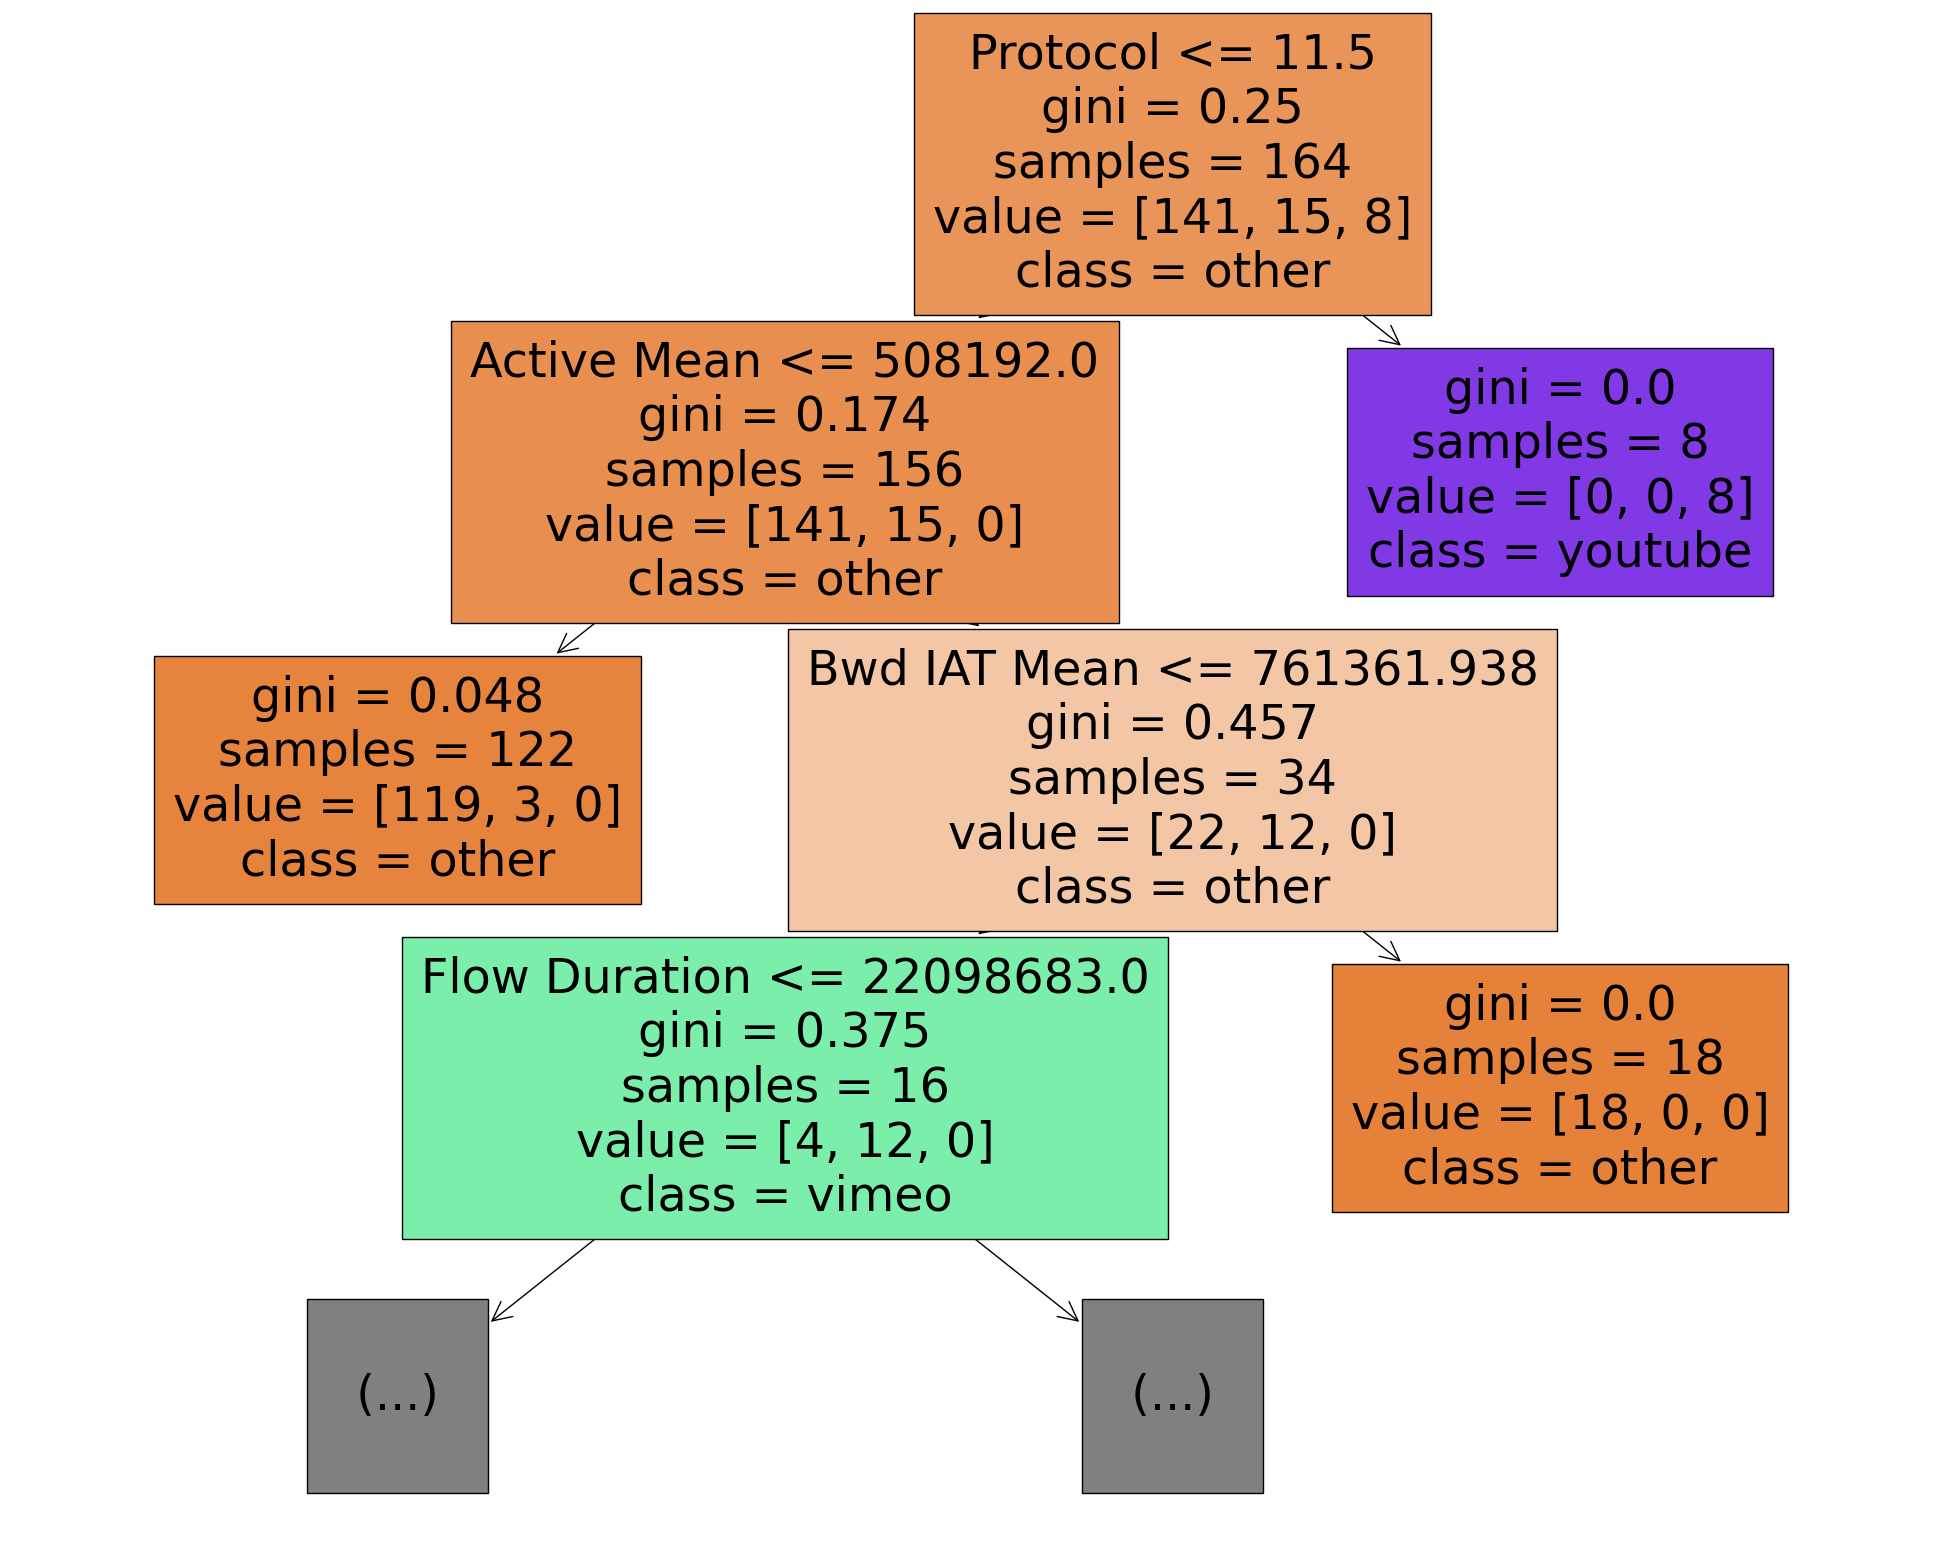

In [34]:
_, dt, _, score = trustee.explain()
print(f"Training score of pruned DT: {score}")
dt_y_pred = dt.predict(x_train)

print("Model explanation global fidelity report:")
print(metrics.classification_report(clf.predict(x_train), dt_y_pred))
print("Model explanation score report:")
print(metrics.classification_report(y_train, dt_y_pred))

fig = plt.figure(figsize=(25,20))
plot_tree(dt, feature_names=x_train.columns, class_names=sorted(df['Label'].unique()), filled=True, max_depth=3)